_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 3

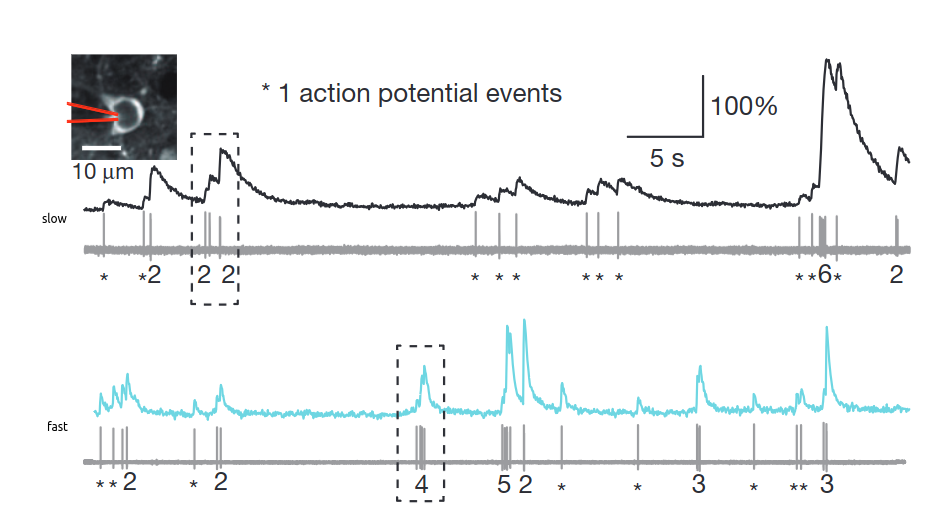

In this notebook you will work with 2 photon calcium recordings from mouse V1 and retina. For details see [Chen et al. 2013](https://www.nature.com/articles/nature12354) and [Theis et al. 2016](https://www.cell.com/neuron/pdf/S0896-6273(16)30073-3.pdf). Two-photon imaging is widely used to study computations in populations of neurons. 

In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For easier analysis, please resample it to 25 Hz. `scipy.signal.decimate` can help here, but note that it is only meant for continous signals. 

__Data__: Download the data file ```nds_cl_3_*.csv``` from ILIAS and save it in a subfolder ```../data/```. Note, some recordings were of shorter duration, hence their columns are padded. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from __future__ import annotations

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-05-06 21:44:16W. Europe Summer Time

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.35.0

sklearn: 1.6.1

numpy     : 2.2.4
pandas    : 2.2.3
matplotlib: 3.10.1
seaborn   : 0.13.2
scipy     : 1.15.2

Watermark: 2.5.0



In [3]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [146]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium_original = pd.read_csv("../data/nds_cl_3_ogb_calcium.csv", header=0)
ogb_spikes_original = pd.read_csv("../data/nds_cl_3_ogb_spikes.csv", header=0)
print(
    f"[OGB] calcium: {ogb_calcium_original.shape}, spikes: {ogb_spikes_original.shape}"
)

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium_original = pd.read_csv("../data/nds_cl_3_gcamp2_calcium.csv", header=0)
gcamp_spikes_original = pd.read_csv("../data/nds_cl_3_gcamp2_spikes.csv", header=0)
print(
    f"[GCaMP] calcium: {gcamp_calcium_original.shape}, spikes: {gcamp_spikes_original.shape}"
)

# spike dataframe
# ogb_spikes.head()

[OGB] calcium: (71986, 11), spikes: (71986, 11)
[GCaMP] calcium: (23973, 37), spikes: (23973, 37)


## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. For the CGamp-dataset a good example is cell 6. Align the traces by eye (add a small offset to the plot) such that a valid comparison is possible and zoom in on a small segment of tens of seconds.

*Grading: 3 pts*

**Question**: Does 'add a small offset to the plot' mean the calcium signal is shifted to earlier (since it also occurs later in time)?

[OGB] calcium: (71986, 11), spikes: (71986, 11)
[OGB] calcium: (17997, 11), spikes: (17997, 11)
[GCaMP] calcium: (23973, 37), spikes: (23973, 37)
[GCaMP] calcium: (5994, 37), spikes: (5994, 37)


C:\Users\aksel\AppData\Local\Temp\ipykernel_19688\430891322.py:27: RuntimeWarning: Mean of empty slice
  mean_rates = np.nanmean(count_rates, axis=1)
C:\Users\aksel\AppData\Local\Temp\ipykernel_19688\430891322.py:28: RuntimeWarning: invalid value encountered in cast
  counts_ds = np.round(mean_rates * dt_downsampled).astype(int)


(30.0, 50.0)

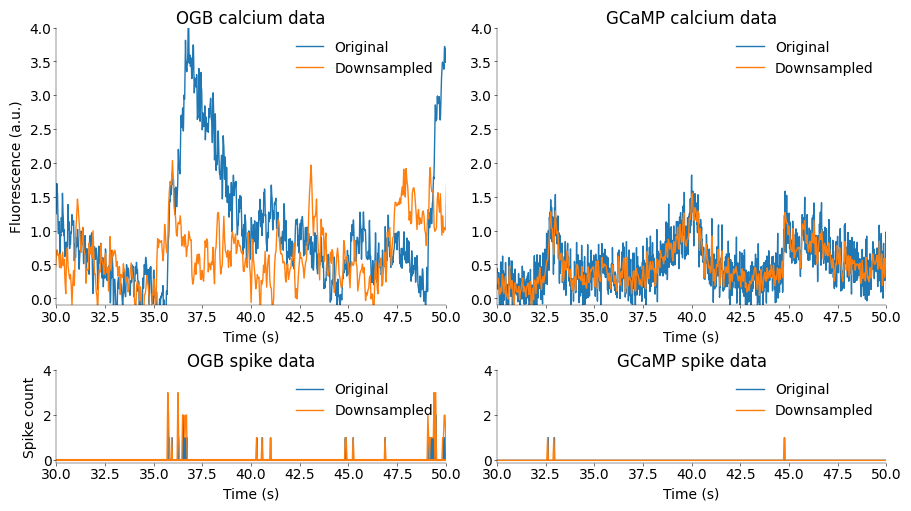

In [200]:
def downsample_counts(counts, fs_orig, fs):
    """
    Downsamples the spike counts by averaging within non-overlapping windows.

    Returns:
    counts_ds : np.ndarray
        Shape (n_times_ds, n_channels) – Downsampled count time series.


    """

    q = int(fs_orig / fs)
    dt_original = 1.0 / fs_orig
    dt_downsampled = 1.0 / fs

    n_bins, n_channels = counts.shape
    n_bins_ds = int(np.ceil(n_bins / q))

    # Pad with zeros if needed to make the array reshapeable
    pad_len = n_bins_ds * q - n_bins
    if pad_len > 0:
        counts = np.pad(counts, ((0, pad_len), (0, 0)), mode="constant")

    # Reshape and average
    counts_reshaped = counts.reshape(n_bins_ds, q, n_channels)
    count_rates = counts_reshaped / dt_original
    mean_rates = np.nanmean(count_rates, axis=1)
    counts_ds = np.round(mean_rates * dt_downsampled).astype(int)

    return counts_ds


fs_orig = 100
fs = 25
q = int(fs_orig / fs)
filter_order = 8

print(
    f"[OGB] calcium: {ogb_calcium_original.shape}, spikes: {ogb_spikes_original.shape}"
)
ogb_calcium = signal.decimate(
    ogb_calcium_original.to_numpy(), q, n=filter_order, axis=0, zero_phase=True
)
ogb_spikes = downsample_counts(ogb_spikes_original.to_numpy(), fs_orig, fs)

print(f"[OGB] calcium: {ogb_calcium.shape}, spikes: {ogb_spikes.shape}")


print(
    f"[GCaMP] calcium: {gcamp_calcium_original.shape}, spikes: {gcamp_spikes_original.shape}"
)

gcamp_calcium = signal.decimate(
    gcamp_calcium_original.to_numpy(), q, n=filter_order, axis=0, zero_phase=True
)

gcamp_spikes = downsample_counts(gcamp_spikes_original.to_numpy(), fs_orig, fs)
print(f"[GCaMP] calcium: {gcamp_calcium.shape}, spikes: {gcamp_spikes.shape}")

# --------------------------------


fig, axs = plt.subplots(
    2, 2, figsize=(9, 5), height_ratios=[3, 1], layout="constrained"
)
# --------------------
# Plot OGB data (1 pt)

cell = 4  # cell 5


# Create time axes for original and downsampled data
time_original = np.arange(0, ogb_calcium_original.shape[0]) / fs_orig
time_downsampled = np.arange(0, ogb_calcium.shape[0]) / fs

# Plot original calcium data
axs[0, 0].plot(
    time_original,
    ogb_calcium_original.iloc[:, cell],
    label="Original",
)
# Plot downsampled calcium data
axs[0, 0].plot(
    time_downsampled,
    ogb_calcium[:, 0],
    label="Downsampled",
)
axs[0, 0].set_ylabel("Fluorescence (a.u.)")
axs[0, 0].set_xlabel("Time (s)")
axs[0, 0].set_title("OGB calcium data")
axs[0, 0].legend()
axs[0, 0].set_xlim(5, 10)

# Plot original spike data
axs[1, 0].plot(
    time_original,
    ogb_spikes_original.iloc[:, cell],
    label="Original",
)
# Plot downsampled spike data
axs[1, 0].plot(
    time_downsampled,
    ogb_spikes[:, cell],
    label="Downsampled",
)
axs[1, 0].set_ylabel("Spike count")
axs[1, 0].set_xlabel("Time (s)")
axs[1, 0].set_title("OGB spike data")
axs[1, 0].legend()

# plot spike data
axs[1, 0].plot(ogb_spikes[:, cell], color="C1", lw=1.5, label="OGB spikes")
axs[1, 0].set_ylabel("Spike count")


# --------------------

# ----------------------
# Plot GCamp data (1 pt)

cell = 5  # cell 6

# Create time axes for original and downsampled data
time_original_gcamp = np.arange(0, gcamp_calcium_original.shape[0]) / fs_orig
time_downsampled_gcamp = np.arange(0, gcamp_calcium.shape[0]) / fs

# Plot original calcium data
axs[0, 1].plot(
    time_original_gcamp,
    gcamp_calcium_original.iloc[:, cell],
    label="Original",
)
# Plot downsampled calcium data
axs[0, 1].plot(
    time_downsampled_gcamp,
    gcamp_calcium[:, cell],
    label="Downsampled",
)

axs[0, 1].set_xlabel("Time (s)")
axs[0, 1].set_title("GCaMP calcium data")
axs[0, 1].legend()

# Plot original spike data
axs[1, 1].plot(
    time_original_gcamp,
    gcamp_spikes_original.iloc[:, cell],
    label="Original",
)
# Plot downsampled spike data
axs[1, 1].plot(
    time_downsampled_gcamp,
    gcamp_spikes[:, cell],
    label="Downsampled",
)


axs[1, 1].set_xlabel("Time (s)")
axs[1, 1].set_title("GCaMP spike data")
axs[1, 1].legend()


for ax in axs.flat:
    ax.set_ylim(-0.1, 4)


# ----------------------

# adjust x-axis window here
start = 30
window = 20  # seconds


axs[0, 0].set_xlim(start, start + window)
axs[0, 1].set_xlim(start, start + window)
axs[1, 0].set_xlim(start, start + window)
axs[1, 1].set_xlim(start, start + window)

**Question**: For the OGB calcium data, the downsampled signal does not seem very well aligned to the original signal, @Caro, Maria any idea why?

## Bonus Task (Optional): Calcium preprocessing

To improve the quality of the inferred spike trains, further preprocessing steps can undertaken. This includes filtering and smoothing of the calcium trace.

Implement a suitable filter and local averaging procedure as discussed in the lecture. Explain your choices and discuss how it helps!

_Grading: 1 BONUS point_

_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). Note there can be no negative rates! Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons. You can use functions from `scipy` for this. Explain your results and your choice of kernel.

*Grading: 6 pts*


In [ ]:
def deconv_ca(ca: np.ndarray, tau: float, dt: float) -> np.ndarray:
    """Compute the deconvolution of the calcium signal.

    Parameters
    ----------

    ca: np.array, (n_points,)
        Calcium trace

    tau: float
        decay constant of conv kernel

    dt: float
        sampling interval.

    Return
    ------

    sp_hat: np.array
    """

    # --------------------------------------------
    # apply devonvolution to calcium signal (1 pt)
    # --------------------------------------------

    return sp_hat

In [ ]:
# -------------------------
# Plot the 2 kernels (1 pt)
# -------------------------
fig, ax = plt.subplots(figsize=(6, 5), layout="constrained")


### Questions (1 pt)
1) Explain how you constructed the kernels

YOUR ANSWER HERE

2) How do the indicators / kernels compare?

YOUR ANSWER HERE

3) What are pros and cons of each indicator?

YOUR ANSWER HERE

In [ ]:
# ----------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB and GCamP cells.
# What do you notice? Why is that? (3 pts)
# ----------------------------------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# GCamp Cell


## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 3 pts*



In [ ]:
# run this cell to download the oopsi.py file and put it in the same folder as this notebook
!wget https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py
import oopsi

In [ ]:
# ----------------------------------------------------------------------
# Apply one of the advanced algorithms to the OGB and GCamp Cells (1 pt)
# ----------------------------------------------------------------------

In [ ]:
# -------------------------------------------------------------------------------
# Plot the results for the OGB and GCamp Cells and describe the results (1+1 pts)
# -------------------------------------------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# GCamP Cell

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package. Note these functions provide useful options for formatting the
plots. See their documentation, i.e. `sns.boxplot?`.

*Grading: 5 pts*


First, evaluate on OGB data and create OGB dataframe. Then repeat for GCamp and combine the two dataframes.

In [ ]:
# ----------------------------------------------------------
# Evaluate the algorithms on the OGB and GCamp cells (2 pts)
# ----------------------------------------------------------

In [ ]:
# -------------------------------
# Construct the dataframe (1 pts)
# -------------------------------

Combine both dataframes. Plot the performance of each indicator and algorithm. You should only need a single plot for this.

In [ ]:
# ----------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described. (1 pt)
# Describe and explain the results briefly. (1 pt)
# ----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")
